In [7]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img,img_to_array,array_to_img
from keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Dense, BatchNormalization, DepthwiseConv2D, LeakyReLU, Add, GlobalMaxPooling2D
from keras.models import Model
from skimage.transform import resize
from PIL import Image, ImageOps

import glob, os, random

In [8]:
base_path = 'Images/Cropped Images/'

img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

print(len(img_list))

4580


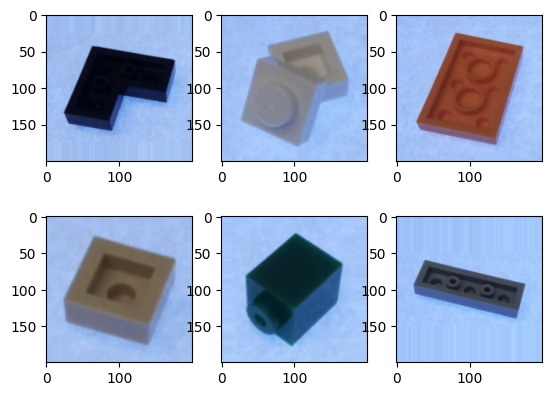

In [10]:
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    
    img = img_to_array(img, dtype=np.uint8)
    
    old_size = img.shape[:2]
    ratio = 200. / max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    img = resize(img, output_shape=new_size, mode='edge', preserve_range=True).astype(np.uint8)
    
    delta_w = 200 - new_size[1]
    delta_h = 200 - new_size[0]
    padding = ((delta_h//2, delta_h-(delta_h//2)), (delta_w//2, delta_w-(delta_w//2)), (0, 0))
    
    img = np.pad(img, padding, 'edge')

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [11]:
def resize_pad(img):
    old_size = img.shape[:2]
    ratio = 200. / max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    img = resize(img, output_shape=new_size, mode='edge', preserve_range=True)
    
    delta_w = 200 - new_size[1]
    delta_h = 200 - new_size[0]
    padding = ((delta_h//2, delta_h-(delta_h//2)), (delta_w//2, delta_w-(delta_w//2)), (0, 0))
    
    img = np.pad(img, padding, 'edge')
    
    return img

def preprocessing_train(x):
    x = resize_pad(x)
    return x

def preprocessing_val(x):
    x = resize_pad(x)
    return x

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing_train,
    rescale=1./255,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing_val,
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    color_mode='grayscale',
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    color_mode='grayscale',
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=0
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

Found 4133 images belonging to 20 classes.
Found 447 images belonging to 20 classes.
{0: 'Brick_1x1', 1: 'Brick_1x2', 2: 'Brick_1x3', 3: 'Brick_1x4', 4: 'Brick_2x2', 5: 'Brick_2x2_L', 6: 'Brick_2x2_Slope', 7: 'Brick_2x3', 8: 'Brick_2x4', 9: 'Plate_1x1', 10: 'Plate_1x1_Round', 11: 'Plate_1x1_Slope', 12: 'Plate_1x2', 13: 'Plate_1x2_Grill', 14: 'Plate_1x3', 15: 'Plate_1x4', 16: 'Plate_2x2', 17: 'Plate_2x2_L', 18: 'Plate_2x3', 19: 'Plate_2x4'}


In [12]:
inputs = Input(shape=(200, 200, 1))

net = Conv2D(filters=64, kernel_size=3, padding='same')(inputs)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

net = Conv2D(filters=64, kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

net = Conv2D(filters=64, kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

shortcut = net

net = DepthwiseConv2D(kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)

net = Conv2D(filters=64, kernel_size=1, padding='same')(net)
net = LeakyReLU()(net)

net = DepthwiseConv2D(kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)

net = Conv2D(filters=64, kernel_size=1, padding='same')(net)
net = LeakyReLU()(net)

net = Add()([shortcut, net])

net = Conv2D(filters=64, kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

net = Conv2D(filters=64, kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

net = DepthwiseConv2D(kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)

net = Conv2D(filters=128, kernel_size=1, padding='same')(net)
net = LeakyReLU()(net)

net = Flatten()(net)

net = Dense(128, activation='relu')(net)

net = Dense(64, activation='relu')(net)

outputs = Dense(20, activation='softmax')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 200, 200, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 200, 200, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [13]:
model.fit_generator(train_generator, epochs=50, validation_data=validation_generator)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7088\3705185182.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=50, validation_data=validation_generator)


Epoch 1/50
130/130 [==============================] - 182s 1s/step - loss: 2.9904 - acc: 0.0661 - val_loss: 2.9857 - val_acc: 0.0716
Epoch 2/50
130/130 [==============================] - 153s 1s/step - loss: 2.9854 - acc: 0.0707 - val_loss: 2.9328 - val_acc: 0.0984
Epoch 3/50
130/130 [==============================] - 146s 1s/step - loss: 2.8123 - acc: 0.1154 - val_loss: 2.5939 - val_acc: 0.1745
Epoch 4/50
130/130 [==============================] - 137s 1s/step - loss: 2.4111 - acc: 0.2233 - val_loss: 2.2552 - val_acc: 0.2573
Epoch 5/50
130/130 [==============================] - 151s 1s/step - loss: 2.1824 - acc: 0.2782 - val_loss: 2.0026 - val_acc: 0.3356
Epoch 6/50
130/130 [==============================] - 142s 1s/step - loss: 2.0176 - acc: 0.3230 - val_loss: 1.9321 - val_acc: 0.3423
Epoch 7/50
130/130 [==============================] - 140s 1s/step - loss: 1.9079 - acc: 0.3644 - val_loss: 1.8099 - val_acc: 0.3870
Epoch 8/50
130/130 [==============================] - 139s 1s/step - 